## Self-Organizing Maps  

Self-organizing maps can be viewed as a hybrid of clustering and dimensionality reduction. After training each feature vector in a dataset is mapped to a discrete grid location. Each grid location is characterized by the average of all the feature vectors that are mapped to it similarly to k-Means clustering. However, when a feature vector is assigned to the best matching grid location this assignment also influences a neighborhood around it. The result is a clustering of values that preserves the topology of the original feature space. 

When used for music collection visualizations the resulting representation is a discrete grid rather than a continuous space as is the case with dimensionality reduction and manifold learning methods. In SOM visualizations there is a less "empty" space. This makes SOM visualizations better suited for user interaction for example on tabletop displays or grid MIDI controllers. 

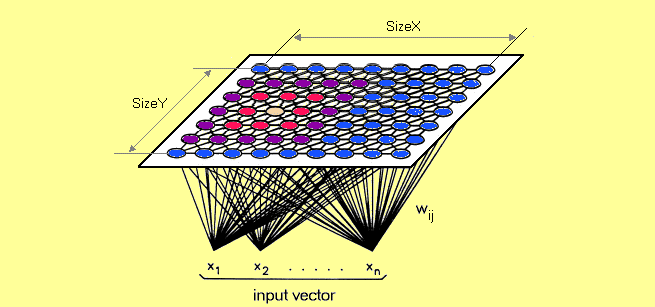

### Colors 

To gain some insights about how SOM works let's examine an example in which a set of color 15 colors are used as input. As the weights of the SOM in these case are RGB values we can directly visualize them. As can be seen patches around each initial color are formed and colors that are similar are placed in close location on the self-organizing map. 

 [ 268 / 500 ]  54% - 0:00:00 left 

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.4425931972321884e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


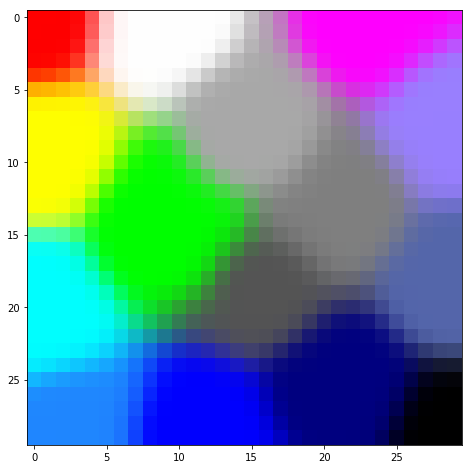

In [9]:
from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Training inputs for RGBcolors
colors = [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]]
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

som = MiniSom(30, 30, 3, sigma=3., 
              learning_rate=2.5, 
              neighborhood_function='gaussian')
som.train_random(colors, 500, verbose=True)
fig = plt.figure(1, figsize=(8, 8))
plt.imshow(abs(som.get_weights()), interpolation='none')


### Visualizing Music Tracks based on audio features  

Let's explore how we can use a SOM visualization for the 3 genre dataset we explored in dimensionality reduction and manifold learning. To refresh our memory let's look at two visualizations using PCA and t-SNE. In both case the original high-dimensional feature vectors (124 dimensios per track) are mapped to a contiuous 2-dimensional space. The colors are used to show that the resulting space preserves information captured by the features related to genre but is not used by the PCA and t-SNE.  

The resulting visualizations tries to preserve the distances and topology of the high-dimensional feature space. 
Because of this there is a lot of empty space in the visualization. As we will see with the SOM the topology but not the distances are preserved resulting in a more dense space. 

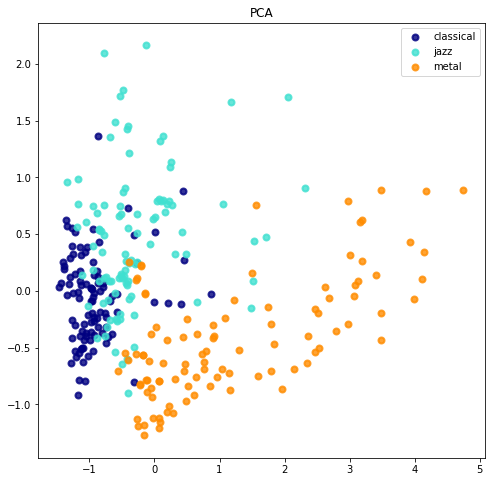

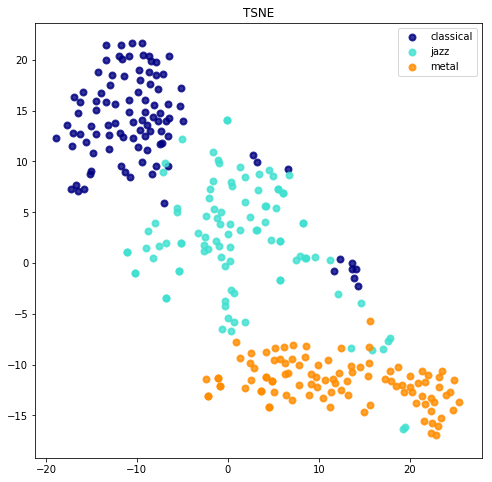

In [4]:
from sklearn import datasets
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

(Xsparse, y) = datasets.load_svmlight_file("data/3genres_full.arff.libsvm")
X = Xsparse.todense()

X = MinMaxScaler().fit_transform(X)
target_names = ['classical', 'jazz', 'metal']
colors = ['navy', 'turquoise', 'darkorange']

def plot_scatter(X, title): 
    lw = 2
    fig = plt.figure(1, figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.8, 
                    lw=lw, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()


# Two dimensional PCA 
X_pca = PCA(n_components=2).fit_transform(X)
plot_scatter(X_pca, 'PCA')

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)
plot_scatter(X_tsne, 'TSNE')

Let's look at a SOM visualization using the same 300 (tracks) by 124 (features) matrix of data mapped to a 10 by 10 grid. We will use the same color convention. As you can see the 3 genres are mostly mosplaced in different areas of the map. 

Training...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.9833724721666041

...ready!


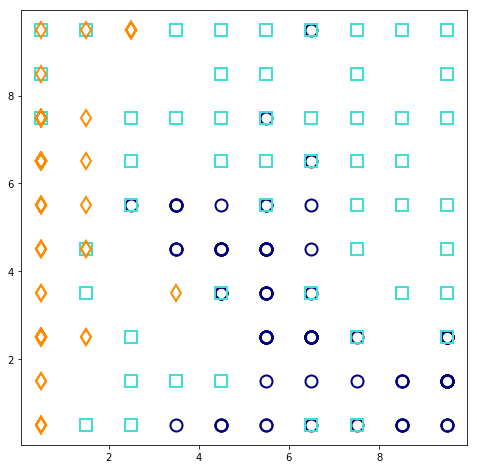

In [5]:
som = MiniSom(10, 10, 124, sigma=3., learning_rate=.7, activation_distance='euclidean', topology='rectangular',
              neighborhood_function='bubble', random_seed=10)

data = X.tolist()
som.pca_weights_init(data)
print("Training...")
som.train_batch(data, 5000, verbose=True)  # random training
print("\n...ready!")

plt.figure(figsize=(8, 8))

# use different colors and markers for each label
markers = ['o', 's', 'd']
#colors = ['C0', 'C1', 'C2']
colors = ['navy', 'turquoise', 'darkorange']

t=y.astype(int)
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)
plt.show()

Each track in the collection gets mapped to one of the locations on the 10 by 10 grid. Some grid locations will get more tracks mapped to them. This is called the activation response. 

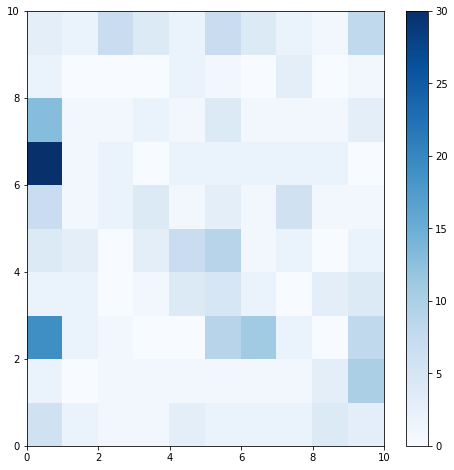

In [6]:
plt.figure(figsize=(8, 8))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

We can also visualize the structure in terms of genre decomposition for each grid location. In this visualization each grid locatio is represented by a pie chart showing the relative proportion of genres for that grid location. As you can see many but not all locations are pure i.e contain a single genre. When connected to playback controls for example continuous playback on a tabletop display or a grid MIDI controller the resulting map can provide a compelling interface for browsing music collections. 

Islands of Music was a neat visualization in which the activition response was mapped so that higher values where shades of brown and lower values where shades of blue and the resulting map was interpolated. The generated islands correspond to different subgroups of similar music. 

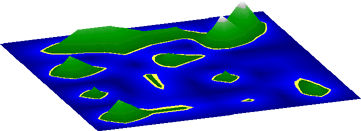

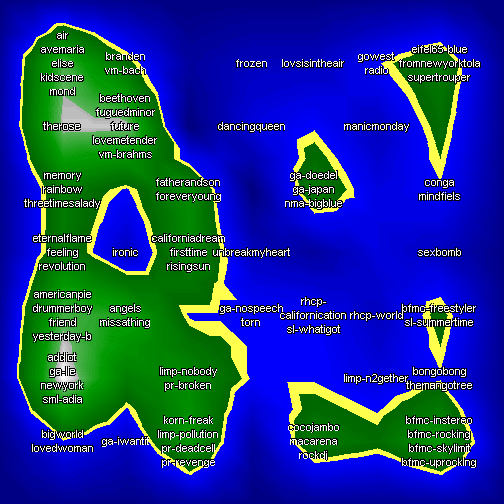

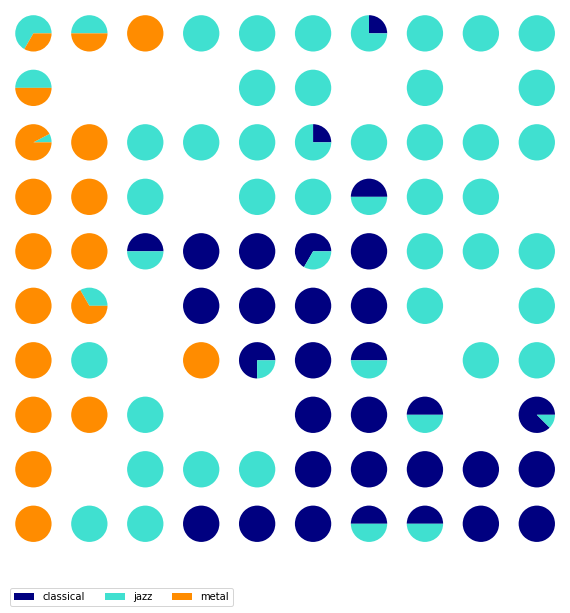

In [8]:

from matplotlib.gridspec import GridSpec

def map_labels(i): 
    if i == 0.0: 
        return "classical"
    elif i == 1.0: 
        return "jazz"
    else:
        return "metal"

label = [map_labels(i) for i in y]
labels_map = som.labels_map(data, label)
label_names = np.unique(label)

plt.figure(figsize=(70, 70))
the_grid = GridSpec(70, 70)

for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[9-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs, colors=['navy', 'turquoise', 'darkorange'])
plt.legend(patches, label_names, bbox_to_anchor=(5., -2.), ncol=3)
plt.show()

The SOM visualization can be used to organize music collections in interesting ways but it is somewhat abstract and takes some time for a user to learn. In order to assist with browsing it is possible to position words in a tag cloud using the SOM visualization. Unlike a traditional tag cloud in which placement is either random or alphabetic we assume that each word applies to a number of tracks. The tracks are mapped to the corresponding grid locations on the SOM and then position of the word is determined by the average of their coordinates. As is common with tag clouds the size of each word is proportional to the number of tracks it applies to. In order to avoid overlap between the words a mass-spring damper simulation is used to push them apart as shown below. 

These are called self-organizing tag clouds and can be used to visualize different facets of music such as tags, genres, artist names, and track names using a common content-derived underlying representation. 

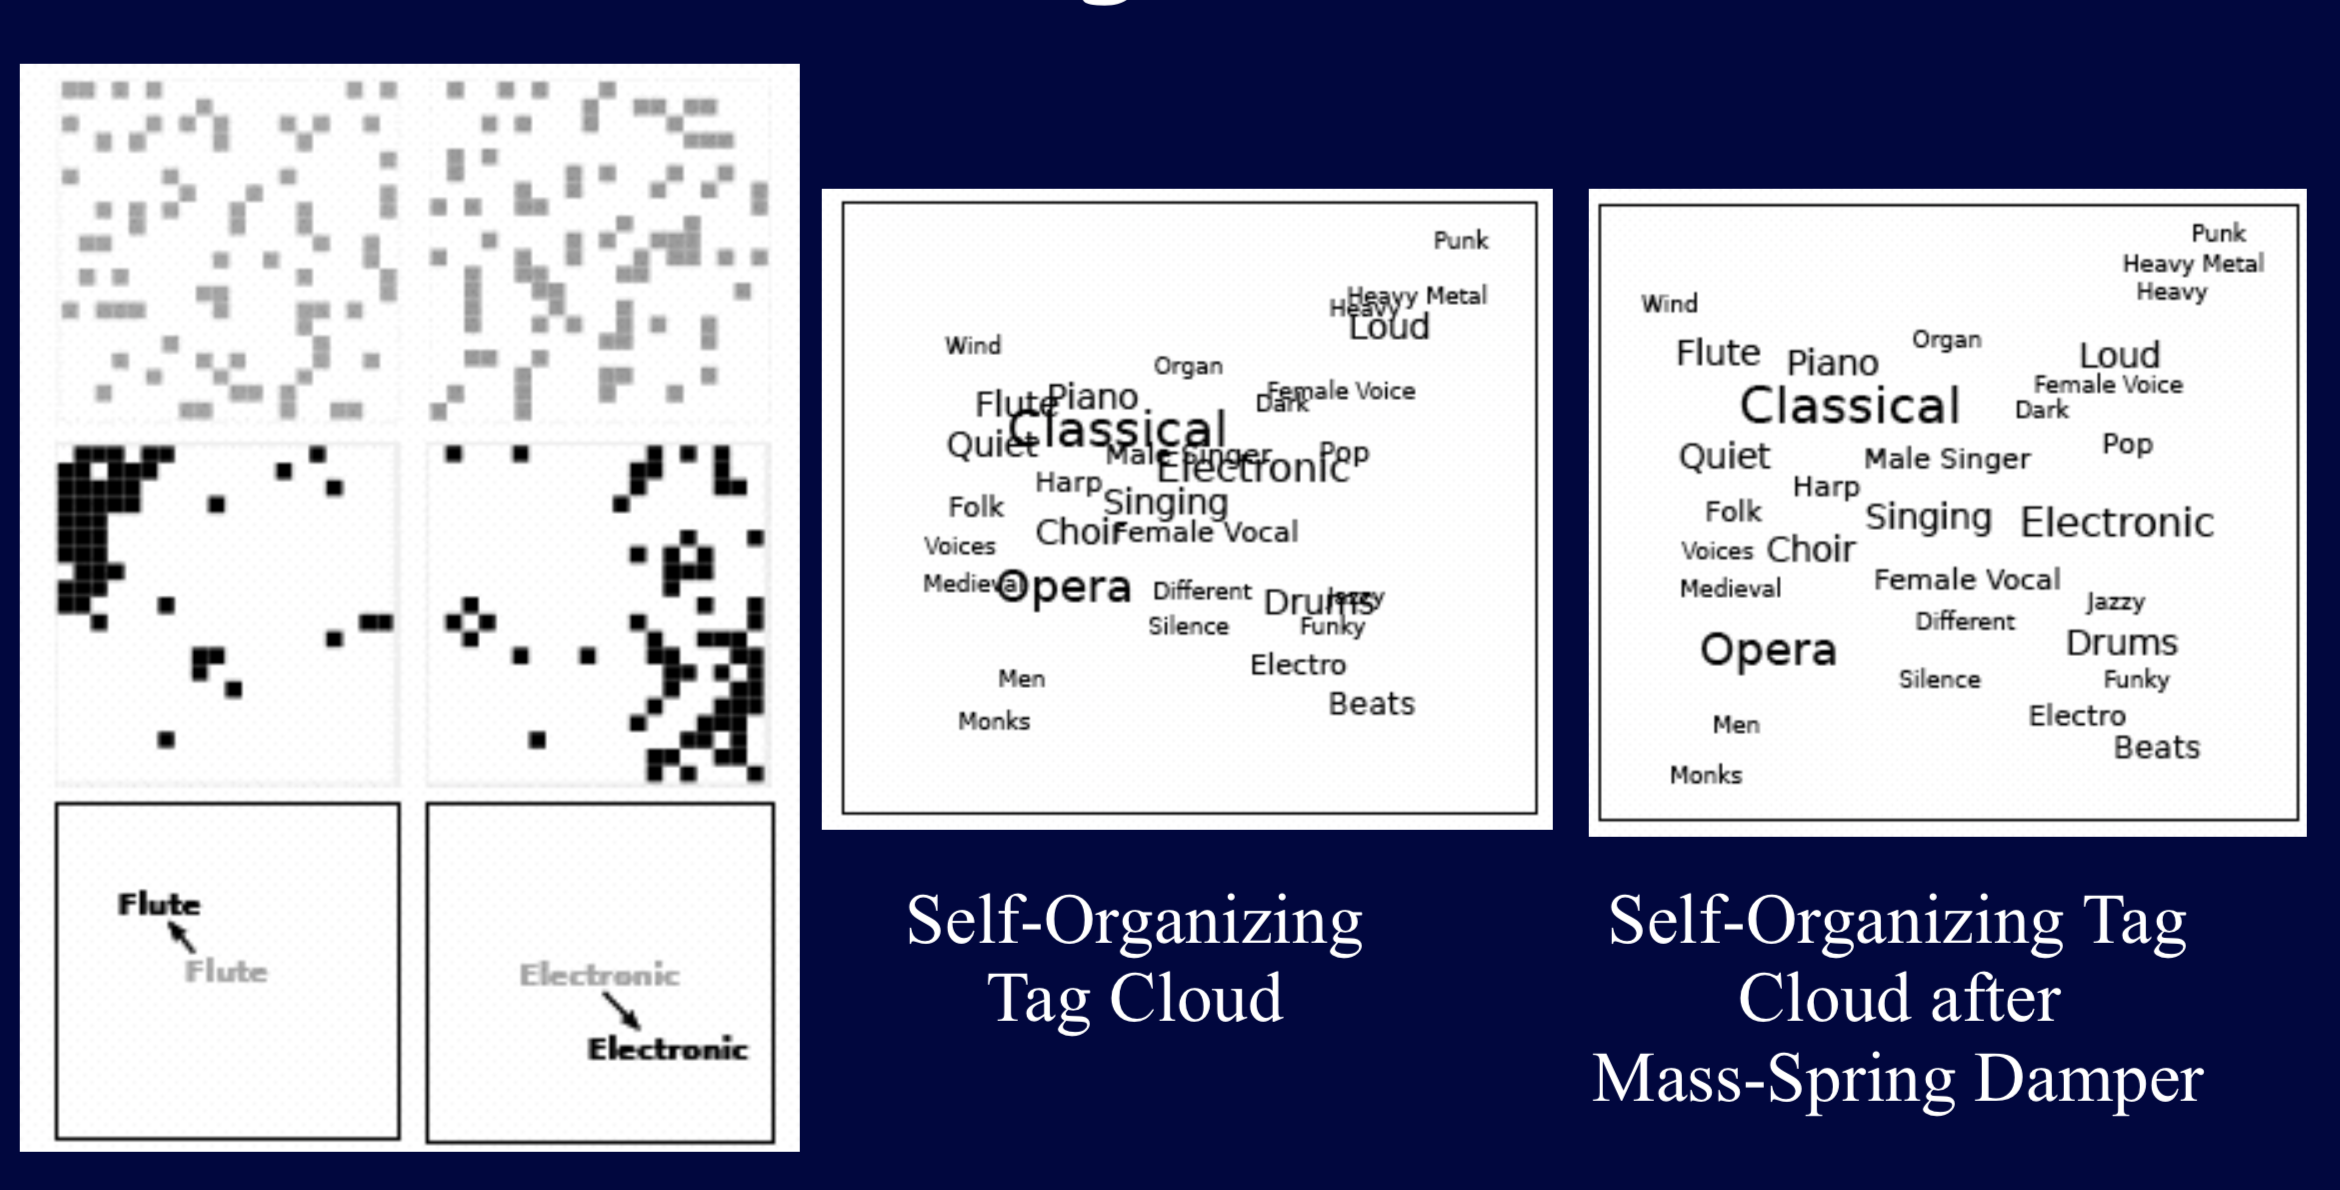